### 1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?

No, it is not OK to initialize all the weights to the same value, even if that value is selected randomly using He initialization. Initializing all weights to the same value would make the neurons symmetric, leading them to learn the same features and gradients, which in turn would prevent the network from learning effectively. It is essential to initialize weights with different values to break the symmetry and allow each neuron to learn different features.

### 2. Is it OK to initialize the bias terms to 0?

Yes, it is generally OK to initialize the bias terms to 0. Unlike weights, biases do not need to break symmetry because they are added after the weights are applied, and their primary role is to shift the activation function. Therefore, initializing biases to 0 is a common practice.

### 3. Name three advantages of the SELU activation function over ReLU.

1. **Self-Normalizing:** SELU activation functions tend to push the activations towards zero mean and unit variance, which helps maintain a self-normalizing property throughout the network. This can lead to faster convergence and more stable training.

2. **Internal Covariate Shift Reduction:** By maintaining zero mean and unit variance, SELU helps in reducing the internal covariate shift, which can further improve the training efficiency and convergence speed.

3. **No Dead Neurons:** Unlike ReLU, which can suffer from the dying ReLU problem where neurons can become inactive and never recover, SELU ensures that neurons continue to learn and adapt throughout the training process.

### 4. In which cases would you want to use each of the following activation functions?

- **SELU:**
  - When building deep neural networks with many layers, as it helps in maintaining the self-normalizing property, leading to more stable and faster training.
  - Particularly useful in fully connected deep neural networks.

- **Leaky ReLU (and its variants):**
  - When dealing with the dying ReLU problem, where some neurons become inactive. Leaky ReLU allows a small gradient when the unit is not active.
  - Variants like Parametric ReLU (PReLU) can be useful when the model can learn the optimal slope of the negative part.

- **ReLU:**
  - When training deep neural networks where speed and simplicity are essential.
  - Commonly used in convolutional neural networks (CNNs) due to its efficiency and effectiveness in practice.

- **Tanh:**
  - When the data is centered around zero, as tanh outputs values between -1 and 1, making it useful for dealing with negative input values.
  - Can be preferred over logistic sigmoid in some cases due to its zero-centered output.

- **Logistic (Sigmoid):**
  - When dealing with binary classification problems, especially in the output layer where probabilities are required.
  - Useful for models that require a probabilistic interpretation of the output.

- **Softmax:**
  - In the output layer of neural networks for multi-class classification problems.
  - Converts the logits into probabilities, ensuring that the sum of the probabilities equals 1.

### 5. What may happen if you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?

If the momentum hyperparameter is set too close to 1 (e.g., 0.99999), the updates may become too aggressive and oscillate around the minima, making it difficult for the optimizer to converge. This can lead to unstable training and may cause the optimizer to overshoot the optimal point repeatedly. It is important to find a balance where momentum helps accelerate convergence without causing excessive oscillations.

### 6. Name three ways you can produce a sparse model.

1. **L1 Regularization (Lasso):** Adding an L1 regularization term to the loss function encourages the model to produce weights that are exactly zero, leading to a sparse model.

2. **Pruning:** Removing weights or neurons with the smallest magnitudes after training can produce a sparse model. This can be done gradually during or after the training process.

3. **Sparse Initialization:** Starting with a sparse initialization of the weights, where most weights are set to zero, and only a few are non-zero. This can be particularly useful in certain types of models like sparse autoencoders.

### 7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?

- **Dropout and Training:**
  - Dropout does slow down training because each training iteration involves randomly dropping units, which adds computational overhead. Additionally, the effective learning rate is reduced as the model needs to learn with fewer active neurons in each iteration.

- **Dropout and Inference:**
  - Dropout does not slow down inference because it is typically turned off during the prediction phase. During inference, the full network is used, and the weights are scaled to account for the dropped units during training.

- **MC Dropout:**
  - Monte Carlo (MC) Dropout does slow down inference because it involves performing multiple forward passes with dropout enabled to estimate uncertainty. This requires significantly more computation compared to a single forward pass without dropout.



### 8. Practice training a deep neural network on the CIFAR10 image dataset:

#### a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function

In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.5 MB/s eta 0:00:00


In [3]:
# 1. Import Libraries:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, ELU, AlphaDropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
# 2. Load and Preprocess the Data:

#Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [13]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
def show_random_images(n, a=None, b=None, figsize=(15, 15), x = x_train, y = y_train):
    indices = np.random.choice(np.arange(x.shape[0]), n, replace=False)
    images = x[indices]
    labels = y[indices]

    if np.max(images) < 254.0:
        images = np.uint8(x*255)

    if a is None or b is None:
        # Calculate a and b based on n
        a = int(np.ceil(np.sqrt(n)))
        b = int(np.ceil(n / a))

    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(a, b, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[np.argmax(labels[i])])
    plt.show()


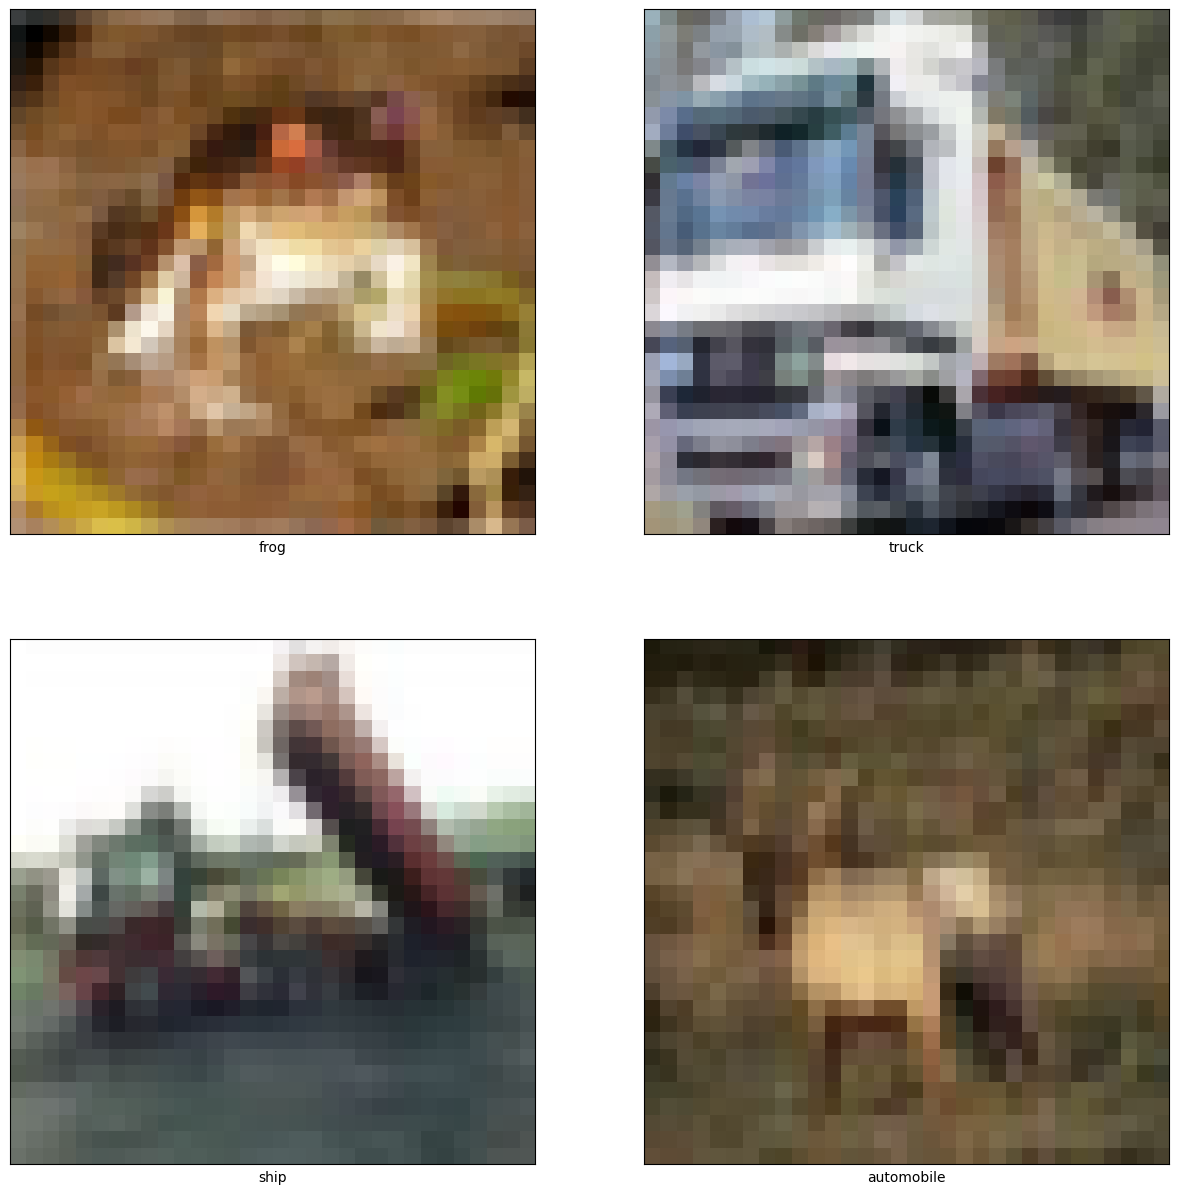

In [22]:
# Example usage
show_random_images(4)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
%cd '/content/drive/Othercomputers/My laptop/Documents/Hands-On Machine Learning with Scikit-Learn and TensorFlow'

/content/drive/Othercomputers/My laptop/Documents/Hands-On Machine Learning with Scikit-Learn and TensorFlow


In [25]:
%ls

chapter_10/
chapter_10.ipynb
chapter_11/
chapter_11.ipynb
chapter_4.ipynb
chapter_5.ipynb
chapter_6.ipynb
chapter_7.ipynb
chapter_8.ipynb
chapter_9.ipynb
classification.ipynb
datasets/
Hands-On_Machine_Learning_with_Scikit-Learn-Keras-and-TensorFlow-2nd-Edition-Aurelien-Geron.pdf
Housing.ipynb
images/
requirements.txt


In [26]:
# Function to create directory for storing models and training data
def get_chapter_directory(chapter_num):
    dir_name = f'chapter_{chapter_num}'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

In [27]:
# Create chapter directory
chapter_dir = get_chapter_directory(11)

In [28]:
# 3. Build the Model:

checkpoint_path = os.path.join(chapter_dir, "cifar10_dnn.weights.h5")
tensorboard_log_dir = os.path.join(chapter_dir, "logs")

# Create callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the model
model = Sequential()

# Flatten the input images
model.add(Flatten())

# Add 20 hidden layers with 100 neurons each, He initialization, and ELU activation
for _ in range(20):
    model.add(Dense(100, kernel_initializer=HeNormal(), activation='elu'))


# Output layer with 10 neurons (one for each class), using softmax activation
model.add(Dense(10, activation='softmax'))

In [29]:
# 4. Compile the model

# Compile the model with SGD optimizer
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Train the model with callbacks
history = model.fit(x_train, y_train,
                    epochs=60,
                    batch_size=32,
                    validation_split=.2,
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])

Epoch 1/60
1250/1250 [==============================] - ETA: 0s - loss: 2.0316 - accuracy: 0.2555
Epoch 1: saving model to chapter_11/cifar10_dnn.weights.h5
1250/1250 [==============================] - 29s 14ms/step - loss: 2.0316 - accuracy: 0.2555 - val_loss: 2.0198 - val_accuracy: 0.2773
Epoch 2/60
1245/1250 [============================>.] - ETA: 0s - loss: 1.8486 - accuracy: 0.3242
Epoch 2: saving model to chapter_11/cifar10_dnn.weights.h5
1250/1250 [==============================] - 15s 12ms/step - loss: 1.8486 - accuracy: 0.3244 - val_loss: 1.8100 - val_accuracy: 0.3298
Epoch 3/60
1247/1250 [============================>.] - ETA: 0s - loss: 1.7946 - accuracy: 0.3462
Epoch 3: saving model to chapter_11/cifar10_dnn.weights.h5
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7948 - accuracy: 0.3460 - val_loss: 1.8217 - val_accuracy: 0.3450
Epoch 4/60
1250/1250 [==============================] - ETA: 0s - loss: 1.7489 - accuracy: 0.3682
Epoch 4: saving model to c

In [32]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.5106 - accuracy: 0.4781


[1.510593056678772, 0.4781000018119812]

In [33]:
from tensorflow.keras.layers import BatchNormalization

In [34]:
checkpoint_path = os.path.join(chapter_dir, "cifar10_dnn_bn.weights.h5")
tensorboard_log_dir = os.path.join(chapter_dir, "logs_bn")

# Create callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)


In [35]:
# Build the model with Batch Normalization
model_bn = Sequential()
model_bn.add(Flatten())
for _ in range(20):
    model_bn.add(Dense(100, kernel_initializer=HeNormal()))
    model_bn.add(BatchNormalization())
    model_bn.add(ELU())
model_bn.add(Dense(10, activation='softmax'))
# Compile the model with Nadam optimizer
model_bn.compile(optimizer=Nadam(learning_rate=0.001),  # Adjust the learning rate as necessary
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [36]:
# Train the model with callbacks
history_bn = model_bn.fit(x_train, y_train,
                          epochs=100,
                          batch_size=32,
                          validation_split=.2,
                          callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])

Epoch 1/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.8535 - accuracy: 0.3363
Epoch 1: saving model to chapter_11/cifar10_dnn_bn.weights.h5
1250/1250 [==============================] - 55s 26ms/step - loss: 1.8533 - accuracy: 0.3363 - val_loss: 1.7759 - val_accuracy: 0.3560
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.3932
Epoch 2: saving model to chapter_11/cifar10_dnn_bn.weights.h5
1250/1250 [==============================] - 30s 24ms/step - loss: 1.6987 - accuracy: 0.3932 - val_loss: 1.9657 - val_accuracy: 0.3302
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 1.6357 - accuracy: 0.4169
Epoch 3: saving model to chapter_11/cifar10_dnn_bn.weights.h5
1250/1250 [==============================] - 30s 24ms/step - loss: 1.6357 - accuracy: 0.4169 - val_loss: 1.7546 - val_accuracy: 0.3765
Epoch 4/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.5892 - accuracy: 0.4322
Epoch 4: savi

In [37]:
model_bn.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4262 - accuracy: 0.5094


[1.4262179136276245, 0.5094000101089478]

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
x_test_scaled = scaler.transform(x_test.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)

# Scale the data to the range [-1, 1]
scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler_minmax.fit_transform(x_train_scaled.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
x_test_scaled = scaler_minmax.transform(x_test_scaled.reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)

In [40]:
np.min(x_train_scaled), np.max(x_train_scaled)

(-1.0, 1.0000000000000004)

In [41]:
# Build the model with SELU activation and LeCun Normal initialization
model_selu = Sequential()
model_selu.add(Flatten())
for _ in range(20):
    model_selu.add(Dense(100, kernel_initializer="lecun_normal", activation='selu'))
model_selu.add(Dense(10, activation='softmax'))

In [42]:
checkpoint_path = os.path.join(chapter_dir, "cifar10_lecuninit.weights.h5")
tensorboard_log_dir = os.path.join(chapter_dir, "logs_lecuninit")

# Create callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [43]:
# Compile the model with Nadam optimizer
model_selu.compile(optimizer=Nadam(learning_rate=0.001),  # Adjust the learning rate as necessary
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


In [44]:
# Train the model with callbacks
history_selu = model_selu.fit(x_train_scaled, y_train,
                              epochs=100,
                              batch_size=32,
                              validation_split=.1,
                              callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])


Epoch 1/100
1403/1407 [============================>.] - ETA: 0s - loss: 1.9687 - accuracy: 0.2857
Epoch 1: saving model to chapter_11/cifar10_lecuninit.weights.h5
1407/1407 [==============================] - 27s 13ms/step - loss: 1.9684 - accuracy: 0.2858 - val_loss: 1.8778 - val_accuracy: 0.3280
Epoch 2/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.7780 - accuracy: 0.3622
Epoch 2: saving model to chapter_11/cifar10_lecuninit.weights.h5
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7781 - accuracy: 0.3622 - val_loss: 1.7880 - val_accuracy: 0.3594
Epoch 3/100
1407/1407 [==============================] - ETA: 0s - loss: 1.6875 - accuracy: 0.4006
Epoch 3: saving model to chapter_11/cifar10_lecuninit.weights.h5
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6875 - accuracy: 0.4006 - val_loss: 1.7145 - val_accuracy: 0.4020
Epoch 4/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.6256 - accuracy: 0.4247
Epoc

In [48]:
model_selu.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.4715 - accuracy: 0.4884


[1.4714914560317993, 0.48840001225471497]

In [49]:
# Build the model with SELU activation, LeCun Normal initialization, and Alpha Dropout
model_alpha_dropout = Sequential()
model_alpha_dropout.add(Flatten())
for _ in range(20):
    model_alpha_dropout.add(Dense(100, kernel_initializer="lecun_normal", activation='selu'))
    model_alpha_dropout.add(AlphaDropout(0.1))  # Adjust dropout rate as necessary
model_alpha_dropout.add(Dense(10, activation='softmax'))

In [50]:
checkpoint_path = os.path.join(chapter_dir, "cifar10_mc_alphadrop.weights.h5")
tensorboard_log_dir = os.path.join(chapter_dir, "logs_mc_alphadrop")

# Create callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [51]:
# Compile the model with Nadam optimizer
model_alpha_dropout.compile(optimizer=Nadam(learning_rate=0.001),  # Adjust the learning rate as necessary
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [52]:
# Train the model with callbacks
history_alpha_dropout = model_alpha_dropout.fit(x_train_scaled, y_train,
                                                epochs=100,
                                                batch_size=32,
                                                validation_split=.1,
                                                callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])


Epoch 1/100
1407/1407 [==============================] - ETA: 0s - loss: 2.1427 - accuracy: 0.1980
Epoch 1: saving model to chapter_11/cifar10_mc_alphadrop.weights.h5
1407/1407 [==============================] - 30s 14ms/step - loss: 2.1427 - accuracy: 0.1980 - val_loss: 5.4438 - val_accuracy: 0.2392
Epoch 2/100
1403/1407 [============================>.] - ETA: 0s - loss: 1.9830 - accuracy: 0.2293
Epoch 2: saving model to chapter_11/cifar10_mc_alphadrop.weights.h5
1407/1407 [==============================] - 19s 13ms/step - loss: 1.9826 - accuracy: 0.2293 - val_loss: 4.7514 - val_accuracy: 0.2236
Epoch 3/100
1404/1407 [============================>.] - ETA: 0s - loss: 1.9497 - accuracy: 0.2475
Epoch 3: saving model to chapter_11/cifar10_mc_alphadrop.weights.h5
1407/1407 [==============================] - 19s 14ms/step - loss: 1.9498 - accuracy: 0.2475 - val_loss: 5.5641 - val_accuracy: 0.2420
Epoch 4/100
1407/1407 [==============================] - ETA: 0s - loss: 1.9276 - accuracy: 0.

In [53]:
model_alpha_dropout.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 3.7065 - accuracy: 0.2583


[3.706463575363159, 0.2583000063896179]

In [54]:
# MC Dropout during inference
def mc_dropout_predict(model, x, n_iter=50):
    predictions = np.zeros((n_iter, x.shape[0], 10))
    for i in range(n_iter):
        predictions[i] = model(x, training=True)  # Keep dropout active
    return predictions.mean(axis=0), predictions.std(axis=0)

In [55]:
# Get predictions with MC Dropout
mean_predictions, std_predictions = mc_dropout_predict(model_alpha_dropout, x_test_scaled)

# Evaluate model using the mean predictions
mc_accuracy = np.mean(np.argmax(mean_predictions, axis=1) == np.argmax(y_test, axis=1))
print(f'MC Dropout accuracy: {mc_accuracy}')

MC Dropout accuracy: 0.2629


In [57]:
checkpoint_path = os.path.join(chapter_dir, "cifar10_mc_alphadrop_1cycle.weights.h5")
tensorboard_log_dir = os.path.join(chapter_dir, "logs_mc_alphadrop_1cycle")

# Create callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [58]:
# Define the 1cycle learning rate policy
initial_learning_rate = 1e-4
max_learning_rate = 1e-2
step_size = len(x_train) // 32

def scale_fn(x):
    return 1 / (2. ** (x - 1))

clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=initial_learning_rate,
    maximal_learning_rate=max_learning_rate,
    step_size=step_size,
    scale_fn=scale_fn,
    scale_mode="cycle",
    name="CyclicalLearningRate"
)

In [59]:
# Compile the model with Nadam optimizer using the 1cycle learning rate policy
optimizer = Nadam(learning_rate=clr)
model_alpha_dropout.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [60]:
# Train the model with callbacks
history_alpha_dropout_clr = model_alpha_dropout.fit(x_train_scaled, y_train,
                                                    epochs=100,
                                                    batch_size=32,
                                                    validation_split=.1,
                                                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])


Epoch 1/100
1404/1407 [============================>.] - ETA: 0s - loss: 2.3165 - accuracy: 0.1818
Epoch 1: saving model to chapter_11/cifar10_mc_alphadrop_1cycle.weights.h5
1407/1407 [==============================] - 30s 14ms/step - loss: 2.3165 - accuracy: 0.1817 - val_loss: 2.6613 - val_accuracy: 0.1024
Epoch 2/100
1406/1407 [============================>.] - ETA: 0s - loss: 2.3542 - accuracy: 0.1008
Epoch 2: saving model to chapter_11/cifar10_mc_alphadrop_1cycle.weights.h5
1407/1407 [==============================] - 19s 14ms/step - loss: 2.3542 - accuracy: 0.1008 - val_loss: 2.3397 - val_accuracy: 0.1024
Epoch 3/100
1406/1407 [============================>.] - ETA: 0s - loss: 2.3216 - accuracy: 0.1013
Epoch 3: saving model to chapter_11/cifar10_mc_alphadrop_1cycle.weights.h5
1407/1407 [==============================] - 19s 14ms/step - loss: 2.3216 - accuracy: 0.1013 - val_loss: 2.3711 - val_accuracy: 0.0950
Epoch 4/100
1406/1407 [============================>.] - ETA: 0s - loss: 

In [61]:
model_alpha_dropout.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.1947 - accuracy: 0.1579


[2.1946864128112793, 0.15790000557899475]

In [62]:
# Get predictions with MC Dropout
mean_predictions, std_predictions = mc_dropout_predict(model_alpha_dropout, x_test_scaled)

# Evaluate model using the mean predictions
mc_accuracy = np.mean(np.argmax(mean_predictions, axis=1) == np.argmax(y_test, axis=1))
print(f'MC Dropout accuracy: {mc_accuracy}')

MC Dropout accuracy: 0.1588
